In [10]:
%load_ext autoreload
%autoreload 2

import optuna
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
import numpy as np
import scipy
import seaborn as sns

from steps.prepare_data import load_processed_data, load_split_processed_data
from utils.model import predict, load_model, predict_booster, predict_booster_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
train_data, test_data = load_split_processed_data()

model_name = "BEST_LightGbmV2_p069_r033_090auc_drop_high_correlation.pickle"

train_data_x = train_data.drop(columns=["target"])
train_data_y = train_data["target"]

test_data_x = test_data.drop(columns=["target"])
test_data_y = test_data["target"]

print("-----------Train----------")
predict_booster(model_name, train_data)

print("-----------Test----------")
predict_booster(model_name, test_data)

model, features = load_model(model_name)

-----------Train----------

Metrics
AUC: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    140413
           1       0.92      0.59      0.72      9585

    accuracy                           0.97    149998
   macro avg       0.94      0.79      0.85    149998
weighted avg       0.97      0.97      0.97    149998

-----------Test----------

Metrics
AUC: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    140597
           1       0.69      0.33      0.45      9403

    accuracy                           0.95    150000
   macro avg       0.82      0.66      0.71    150000
weighted avg       0.94      0.95      0.94    150000



Train data shape: (149998, 586)
Test data shape: (150000, 805)


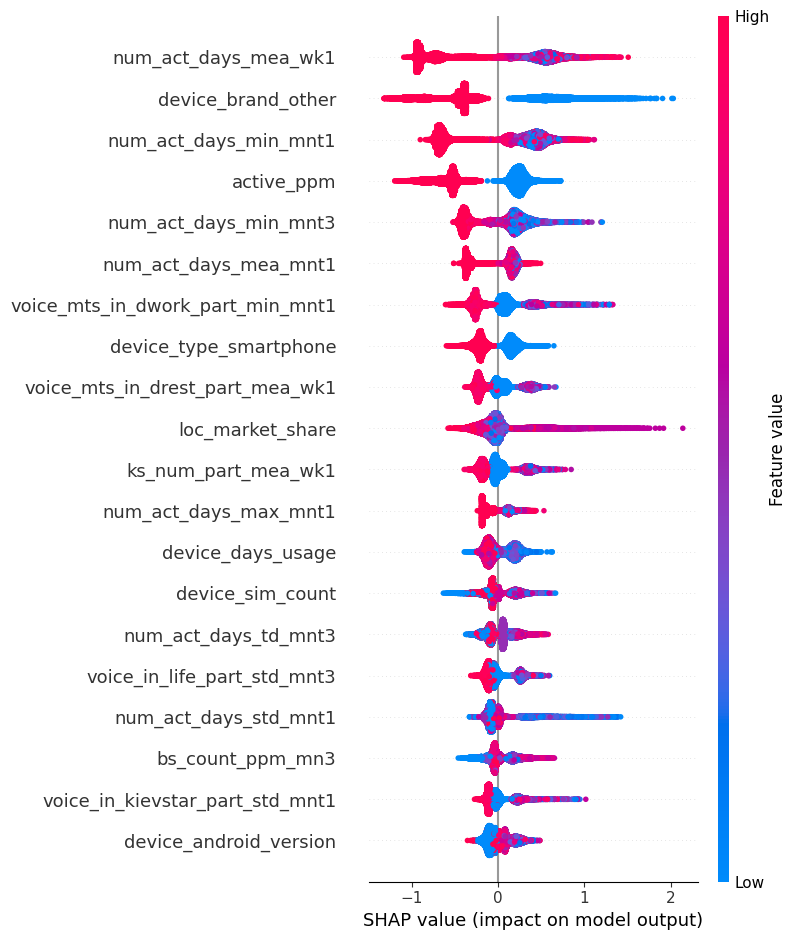

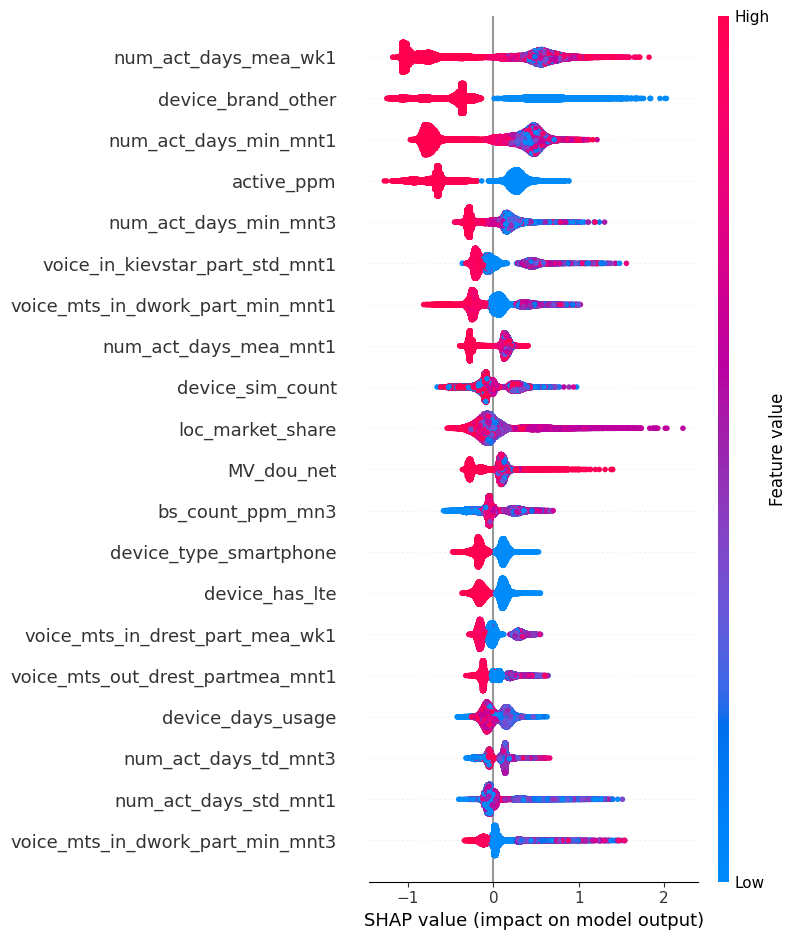

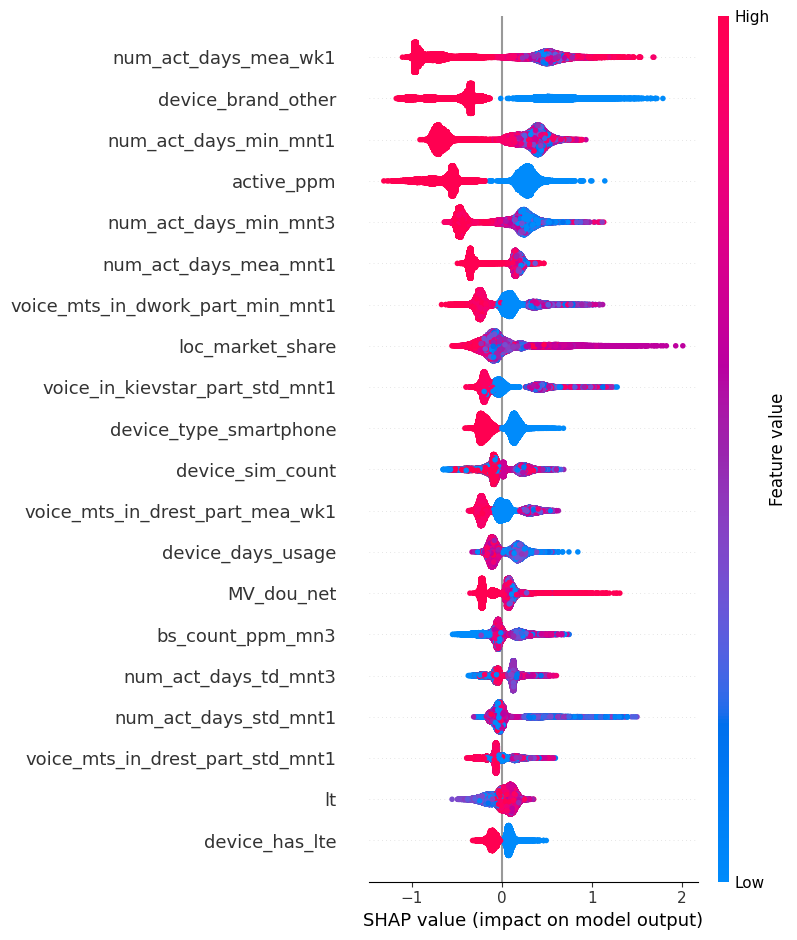

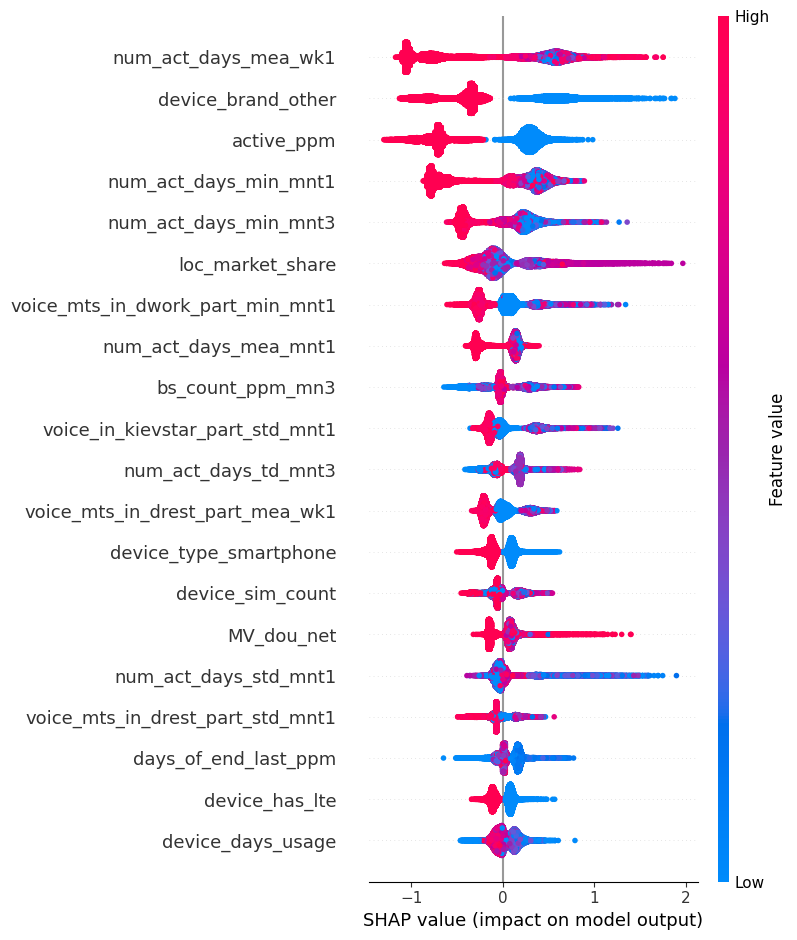

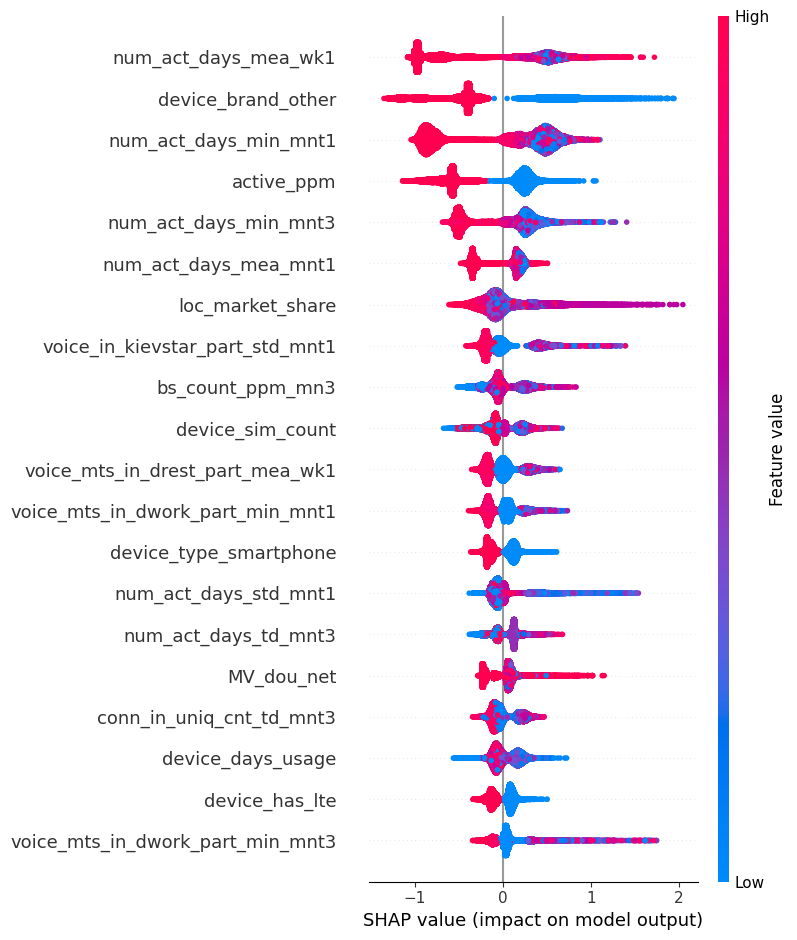

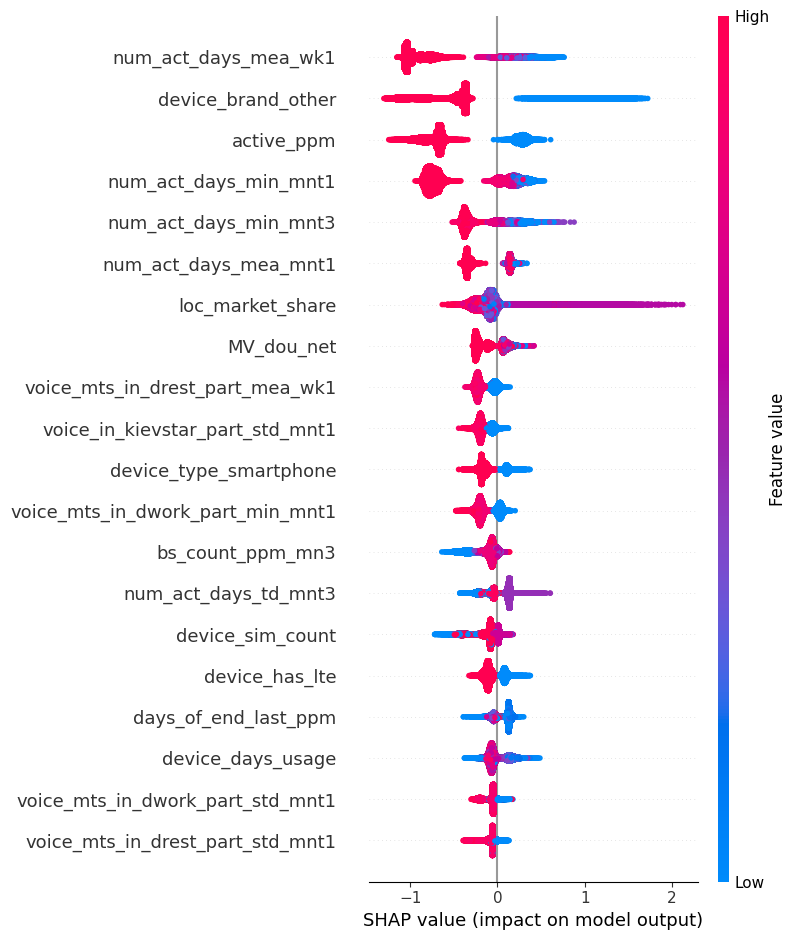

Score:  0.9215770824349196


In [6]:
import json
import pickle
import optuna
from utils.helpers import create_or_load_optuna_study
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
from utils.model import save_model
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
from datetime import datetime
from imblearn.over_sampling import SMOTE
from steps.prepare_data import load_split_processed_data, process_train_data, process_test_data
import sklearn
import random
from sklearn.model_selection import train_test_split, KFold
import warnings
import pdb

params = {
    "random_state": 42,
    "seed": 42,
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "feature_pre_filter": False,
    "lambda_l1": 0.05222186194907641,
    "lambda_l2": 0.0004968956497707999,
    "learning_rate": 0.09876614458681757,
    "num_leaves": 177,
    "feature_fraction": 0.671500638712106,
    "bagging_fraction": 0.7539408355912318,
    "max_depth": 52,
    "min_child_samples": 77,
    "early_stopping_rounds": 106,
}


warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

train_data, test_data = load_split_processed_data()

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

train_x = train_data.drop("target", axis=1)
train_y = train_data.target

valid_x = test_data.drop("target", axis=1)[train_x.columns]
valid_y = test_data.target

smote = SMOTE(sampling_strategy="auto", random_state=SEED)
resampled_x, resampled_y = smote.fit_resample(train_x, train_y)

dtrain = lgb.Dataset(resampled_x, label=resampled_y)
dvalid = lgb.Dataset(valid_x, label=valid_y, reference=dtrain)

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
f1_scores = []
auc_scores = []
shap_importances = []

for train_index, val_index in kf.split(resampled_x):
    X_train = resampled_x.iloc[train_index]
    y_train = resampled_y.iloc[train_index]

    X_val = resampled_x.iloc[val_index]
    y_val = resampled_y.iloc[val_index]

    kfold_dtrain = lgb.Dataset(X_train, label=y_train)
    kfold_dvalid = lgb.Dataset(X_val, label=y_val, reference=kfold_dtrain)

    model = lgb.train(
        params,
        kfold_dtrain,
        valid_sets=[kfold_dvalid],
    )

    y_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)
    threshold = 0.5
    y_pred = (y_pred_proba >= threshold).astype(int)

    f1_score = sklearn.metrics.f1_score(y_val, y_pred)
    auc_score = sklearn.metrics.roc_auc_score(y_val, y_pred_proba)

    f1_scores.append(f1_score)
    auc_scores.append(auc_score)

    # Model interpretation using SHAP
    explainer = shap.Explainer(model)
    shap_values = explainer(X_val)
    shap.summary_plot(shap_values, X_val)

    shap_importance = pd.DataFrame(
        list(zip(X_val.columns, np.abs(shap_values.values).mean(axis=0))), columns=["feature", "importance"]
    ).sort_values(by="importance", ascending=False)

    shap_importances.append(shap_importance)

validation_gbm = lgb.train(
    params,
    dtrain,
    valid_sets=[dvalid],
)

y_pred_proba = validation_gbm.predict(valid_x, num_iteration=validation_gbm.best_iteration)
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

f1_score = sklearn.metrics.f1_score(valid_y, y_pred)
auc_score = sklearn.metrics.roc_auc_score(valid_y, y_pred_proba)

f1_scores.append(f1_score)
auc_scores.append(auc_score)

# Model interpretation using SHAP
explainer = shap.Explainer(validation_gbm)
shap_values = explainer(valid_x)
shap.summary_plot(shap_values, valid_x)

shap_importance = pd.DataFrame(
    list(zip(valid_x.columns, np.abs(shap_values.values).mean(axis=0))), columns=["feature", "importance"]
).sort_values(by="importance", ascending=False)

shap_importances.append(shap_importance)

print("Score: ", 0.4 * np.mean(auc_scores) + 0.6 * np.mean(f1_scores))

In [11]:
predict_booster_model(validation_gbm, train_data)
predict_booster_model(validation_gbm, test_data[train_data.columns])


Metrics
AUC: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    140413
           1       0.90      0.53      0.67      9585

    accuracy                           0.97    149998
   macro avg       0.93      0.76      0.82    149998
weighted avg       0.96      0.97      0.96    149998


Metrics
AUC: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    140597
           1       0.68      0.33      0.45      9403

    accuracy                           0.95    150000
   macro avg       0.82      0.66      0.71    150000
weighted avg       0.94      0.95      0.94    150000



array([0, 0, 0, ..., 0, 0, 1])

In [133]:
# # import the package
# import target_permutation_importances as tpi

# # Compute permutation importances with your parameters
# result_df = tpi.compute(
#     model_cls=type(gbm_model),
#     model_cls_params=gbm_model.get_params(),
#     model_fit_params={},
#     X=valid_x_for_permutation,
#     y=valid_y,
#     num_actual_runs=2,
#     num_random_runs=10,
#     permutation_importance_calculator=tpi.compute_permutation_importance_by_subtraction,
# )

# print(result_df[["feature", "importance"]].sort_values("importance", ascending=False).head())

In [70]:
# ti_data = result_df[["feature", "importance"]].sort_values("importance", ascending=False)

In [134]:
# ti_data[ti_data.importance > 0]

# ti_data = result_df[["feature", "importance"]].sort_values("importance", ascending=False)
# ti_data = ti_data[ti_data.importance > 0]
# ti_data.rename(columns={"importance": "TI_Rating"}, inplace=True)

# merged_df = merged_df.merge(ti_data, on="feature", how="left")

# merged_df["Rating_with_TI"] = merged_df[["Rating", "TI_Rating"]].sum(axis=1)
# merged_df = merged_df.drop(columns=["TI_Rating"])

In [101]:
df_copy = shap_importances.copy()

df0 = df_copy[0].rename(columns={"importance": "importance 0"})
df1 = df_copy[1].rename(columns={"importance": "importance 1"})
df2 = df_copy[2].rename(columns={"importance": "importance 2"})
df3 = df_copy[3].rename(columns={"importance": "importance 3"})
df4 = df_copy[4].rename(columns={"importance": "importance 4"})
df5 = df_copy[5].rename(columns={"importance": "importance 5"})

dataframes = [df1, df2, df3, df4, df5]
merged_df = df0

for df in dataframes:
    merged_df = merged_df.merge(df, on="feature")

merged_df["Rating"] = merged_df[
    ["importance 0", "importance 1", "importance 2", "importance 3", "importance 4", "importance 5"]
].mean(axis=1)

features_importance_df = merged_df.copy()

merged_df[merged_df.Rating > 0.02].sort_values(by="Rating", ascending=False)

,feature,importance 0,importance 1,importance 2,importance 3,importance 4,importance 5,Rating
0,num_act_days_mea_wk1,0.640149,0.694267,0.642744,0.700652,0.650565,0.771562,0.683323
1,device_brand_other,0.553956,0.536548,0.522199,0.511399,0.582198,0.603381,0.551614
2,num_act_days_min_mnt1,0.478426,0.518036,0.461966,0.465263,0.556520,0.536828,0.502840
3,active_ppm,0.395412,0.456265,0.434425,0.492307,0.411549,0.597095,0.464509
4,num_act_days_min_mnt3,0.275582,0.214804,0.309315,0.298892,0.342344,0.282840,0.287296
...,...,...,...,...,...,...,...,...
57,data_3g_tv_cnt_std_mnt3,0.029803,0.023939,0.026808,0.016795,0.019992,0.014593,0.021988
97,sms_in_cnt_mea_wk1,0.017758,0.022652,0.027627,0.025722,0.017980,0.018371,0.021685
106,voice_mts_out_drest_partmin_mnt1,0.016470,0.023193,0.015202,0.029328,0.027926,0.017343,0.021577
118,sms_in_cnt_mea_mnt3,0.013791,0.035006,0.014632,0.017998,0.028671,0.018960,0.021510


In [94]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

# Variance threshold
threshold = 0.0  # Set your desired threshold for variance

# VarianceThreshold method
selector = VarianceThreshold(threshold=threshold)
selector.fit(train_data_x)

# Get the mask of features that pass the threshold
mask = selector.get_support()

# Filter the DataFrame
filtered_df = train_data_x.loc[:, mask]

(149998, 540)

In [103]:
columns_with_low_variance = train_data_x.columns.difference(filtered_df.columns)

columns_with_low_variance

Index(['Ama_rchrgmnt_sum_max_mnt1', 'Ama_rchrgmnt_sum_max_mnt3',
       'Ama_rchrgmnt_sum_mea_mnt1', 'Ama_rchrgmnt_sum_mea_mnt3',
       'Ama_rchrgmnt_sum_mea_wk1', 'Ama_rchrgmnt_sum_min_mnt1',
       'Ama_rchrgmnt_sum_min_mnt3', 'Ama_rchrgmnt_sum_std_mnt1',
       'Ama_rchrgmnt_sum_std_mnt3', 'Ama_rchrgmnt_sum_td_mnt3',
       'CALCULATION_METHOD_ID', 'MV_ARPU_Other_inc_v_Traf',
       'MV_ARPU_Other_out_v_Traf', 'MV_ARPU_innet_inc_v_Traf',
       'MV_Traf_Cont_inc_v_Min', 'MV_Traf_Other_out_v_Min', 'MV_ap_2G_d',
       'MV_ap_3G_d', 'MV_ap_Cont_v', 'MV_ap_Roam_d', 'MV_ap_inc_v',
       'MV_ot_R_sm', 'MV_ot_inc_v', 'all_roam_clc_min_mnt1',
       'all_roam_clc_min_mnt3', 'goodok_clc_max_mnt1', 'goodok_clc_max_mnt3',
       'goodok_clc_mea_mnt1', 'goodok_clc_mea_mnt3', 'goodok_clc_mea_wk1',
       'goodok_clc_min_mnt1', 'goodok_clc_min_mnt3', 'goodok_clc_std_mnt1',
       'goodok_clc_std_mnt3', 'goodok_clc_td_mnt3', 'pay_p2p_in_sum_min_mnt3',
       'pay_p2p_out_sum_max_mnt3', 'sms_roa

In [188]:
data = features_importance_df[~features_importance_df.feature.isin(columns_with_low_variance)]
data = features_importance_df[features_importance_df.Rating > 0.02].sort_values(by="Rating", ascending=False)

data

,feature,importance 0,importance 1,importance 2,importance 3,importance 4,importance 5,Rating
0,num_act_days_mea_wk1,0.640149,0.694267,0.642744,0.700652,0.650565,0.771562,0.683323
1,device_brand_other,0.553956,0.536548,0.522199,0.511399,0.582198,0.603381,0.551614
2,num_act_days_min_mnt1,0.478426,0.518036,0.461966,0.465263,0.556520,0.536828,0.502840
3,active_ppm,0.395412,0.456265,0.434425,0.492307,0.411549,0.597095,0.464509
4,num_act_days_min_mnt3,0.275582,0.214804,0.309315,0.298892,0.342344,0.282840,0.287296
...,...,...,...,...,...,...,...,...
57,data_3g_tv_cnt_std_mnt3,0.029803,0.023939,0.026808,0.016795,0.019992,0.014593,0.021988
97,sms_in_cnt_mea_wk1,0.017758,0.022652,0.027627,0.025722,0.017980,0.018371,0.021685
106,voice_mts_out_drest_partmin_mnt1,0.016470,0.023193,0.015202,0.029328,0.027926,0.017343,0.021577
118,sms_in_cnt_mea_mnt3,0.013791,0.035006,0.014632,0.017998,0.028671,0.018960,0.021510


In [189]:
features_v1_df = data

features_v1 = data.feature.to_list()

features_v1

['num_act_days_mea_wk1',
 'device_brand_other',
 'num_act_days_min_mnt1',
 'active_ppm',
 'num_act_days_min_mnt3',
 'num_act_days_mea_mnt1',
 'loc_market_share',
 'voice_mts_in_dwork_part_min_mnt1',
 'voice_in_kievstar_part_std_mnt1',
 'device_type_smartphone',
 'voice_mts_in_drest_part_mea_wk1',
 'bs_count_ppm_mn3',
 'device_sim_count',
 'MV_dou_net',
 'num_act_days_td_mnt3',
 'device_days_usage',
 'device_has_lte',
 'num_act_days_std_mnt1',
 'voice_mts_in_drest_part_std_mnt1',
 'days_of_end_last_ppm',
 'voice_mts_in_dwork_part_std_mnt1',
 'lt',
 'voice_mts_in_dwork_part_min_mnt3',
 'conn_in_uniq_cnt_td_mnt3',
 'voice_in_life_part_std_mnt3',
 'Balance_uah',
 'ks_num_part_mea_wk1',
 'day_end_gba',
 'voice_mts_in_dwork_part_mea_mnt3',
 'com_num_part_td_mnt3',
 'device_android_version',
 'num_act_days_std_mnt3',
 'voice_mts_out_drest_partmea_mnt1',
 'loc_is_obl_center',
 'num_act_days_max_mnt1',
 'conn_com_part_min_mnt1',
 'voice_mts_out_dwork_partmea_mnt3',
 'device_type_phone',
 'voice

In [116]:
features_v0 = [
    "voice_in_td_cnt_mea_mnt1",
    "lt",
    "num_act_days_td_mnt3",
    "num_act_days_min_mnt1",
    "voice_mts_in_dwork_part_mea_mnt1",
    "voice_out_td_cnt_td_mnt3",
    "voice_mts_in_dwork_part_max_mnt1",
    "all_cnt_std_mnt3",
    "all_cnt_min_mnt3",
    "device_days_usage",
    "imei_mean_long_days_usage",
    "num_act_days_std_mnt1",
    "voice_out_short_part_mea_mnt3",
    "Balance_uah",
    "sms_in_cnt_std_mnt3",
    "voice_in_mts_avg_dur_min_mnt3",
    "voice_mts_in_dwork_part_min_mnt3",
    "voice_in_td_cnt_td_mnt3",
    "voice_mts_in_drest_part_td_mnt3",
    "voice_in_tar_dur_min_mnt1",
    "voice_out_td_cnt_min_mnt3",
    "com_num_part_td_mnt3",
    "voice_mts_in_dwork_part_std_mnt1",
    "conn_com_part_min_mnt1",
    "voice_in_kievstar_part_std_mnt1",
    "tsoa_call_cnt",
    "num_act_days_mea_mnt3",
    "active_gba",
    "days_of_end_last_ppm",
    "myvf_day_usage",
    "voice_in_tar_dur_mea_wk1",
    "MV_dou_net",
    "voice_mts_out_dwork_partmea_mnt3",
    "voice_mts_in_nwork_part_mea_mnt1",
    "days_of_last_ppm",
    "num_act_days_max_mnt1",
    "voice_mts_in_dwork_part_max_mnt3",
    "voice_in_kievstar_part_max_mnt3",
    "voice_in_td_cnt_min_mnt1",
    "cnt_paym_6_month",
    "conn_com_part_max_mnt3",
    "abon_id",
    "loc_is_obl_center",
    "data_3g_tv_cnt_std_mnt3",
    "device_brand_other",
    "num_act_days_mea_mnt1",
    "voice_out_tar_dur_min_mnt3",
    "MV_DOU_AP",
    "non_accum_internet_vol_std_mnt3",
    "voice_in_kievstar_part_mea_mnt1",
    "loc_market_share",
    "voice_mts_out_nwork_partmin_mnt1",
    "data_3g_tv_cnt_std_mnt1",
    "sum_paym_6_month",
    "conn_in_uniq_cnt_td_mnt3",
    "num_act_days_mea_wk1",
    "num_act_days_min_mnt3",
    "voice_mts_out_dwork_partmax_mnt3",
    "device_height_mm",
    "active_ppm",
    "voice_mts_in_drest_part_mea_wk1",
    "day_end_gba",
    "ks_num_part_mea_wk1",
    "imei_mean_days_usage",
    "device_type_rus_other",
    "voice_mts_in_dwork_part_mea_mnt3",
    "device_has_lte",
    "non_accum_internet_vol_min_mnt3",
    "voice_mts_in_drest_part_mea_mnt1",
    "device_type_smartphone",
    "num_act_days_std_mnt3",
    "voice_mts_in_dwork_part_min_mnt1",
    "all_cnt_std_mnt1",
    "voice_in_life_part_mea_mnt3",
    "bs_count_ppm_mn3",
    "conn_com_part_max_mnt1",
    "voice_out_tar_dur_mea_wk1",
    "non_accum_internet_vol_mea_wk1",
    "device_type_phone",
    "content_cnt_mea_mnt3",
    "voice_mts_in_drest_part_std_mnt1",
    "gprs_tar_vol_std_mnt1",
    "gprs_tar_vol_min_mnt1",
    "voice_in_kievstar_part_max_mnt1",
    "device_brand_nan",
    "voice_mts_out_nrest_partmea_wk1",
    "device_sim_count",
    "device_android_version",
    "conn_out_uniq_cnt_mea_wk1",
    "MV_dou",
    "avg_paym_6_month",
]

In [136]:
lightGbmV1_p025_r080_090auc = load_model("LightGbmV1_p025_r080_090auc.pickle")
lightGbmV1_p041_r064_089auc = load_model("LightGbmV1_p041_r064_089auc.pickle")
lightGbmV2_p068_r033_090auc = load_model("lightGbmV2_p068_r033_090auc_NEW.pickle")
lightGbmV2_p069_r033_090auc = load_model("lightGbmV2_p069_r033_090auc.pickle")
lightGbmV2_p070_r033_090auc = load_model("lightGbmV2_p070_r033_090auc.pickle")
xgboostV1_p072_r031_090auc = load_model("xgboostV1_p072_r031_090auc.pickle")
lightGbmV2_balanced = load_model("lightGbmV2_balanced.pickle")

processed_train_data, processed_test_data = load_processed_data()
split_processed_train_data, split_processed_test_data = load_split_processed_data()


def shap_info_builder(model_data, dataframe):
    model, features = model_data

    print("Model:", model[0].__class__.__name__)

    explainer = shap.Explainer(model)

    valid_x = dataframe.drop(columns=["target"])

    shap_values = explainer(valid_x)

    shap_importance = pd.DataFrame(
        list(zip(valid_x.columns, np.abs(shap_values.values).mean(axis=0))), columns=["feature", "importance"]
    ).sort_values(by="importance", ascending=False)

    return shap_importance


shap_values = {}

shap_values["lightGbmV1_p025_r080_090auc"] = shap_info_builder(lightGbmV1_p025_r080_090auc, processed_test_data)
shap_values["lightGbmV1_p041_r064_089auc"] = shap_info_builder(lightGbmV1_p041_r064_089auc, processed_test_data)
shap_values["lightGbmV2_p068_r033_090auc"] = shap_info_builder(lightGbmV2_p068_r033_090auc, processed_test_data)
shap_values["lightGbmV2_p069_r033_090auc"] = shap_info_builder(lightGbmV2_p069_r033_090auc, processed_test_data)
shap_values["lightGbmV2_p070_r033_090auc"] = shap_info_builder(lightGbmV2_p070_r033_090auc, processed_test_data)
shap_values["xgboostV1_p072_r031_090auc"] = shap_info_builder(xgboostV1_p072_r031_090auc, processed_test_data)

shap_values

{'lightGbmV1_p025_r080_090auc':                               feature  importance
 480             num_act_days_mea_mnt3    0.192521
 634                 device_days_usage    0.185330
 282             num_act_days_std_mnt3    0.119579
 488             num_act_days_mea_mnt1    0.119198
 432             num_act_days_min_mnt3    0.112614
 ..                                ...         ...
 365            accum_mts_dur_min_mnt3    0.000000
 362  voice_mts_out_drest_partstd_mnt1    0.000000
 361  voice_mts_in_drest_part_min_mnt1    0.000000
 359               ama_volume_mea_mnt1    0.000000
 402            accum_mts_dur_mea_mnt1    0.000000
 
 [804 rows x 2 columns],
 'lightGbmV1_p041_r064_089auc':                             feature  importance
 432           num_act_days_min_mnt3    0.363240
 634               device_days_usage    0.229179
 632                loc_market_share    0.174532
 488           num_act_days_mea_mnt1    0.165297
 604                     Balance_uah    0.133807
 ..  

In [156]:
lightGbmV1_p025_r080_090auc_report = shap_values["lightGbmV1_p025_r080_090auc"].copy()
lightGbmV1_p041_r064_089auc_report = shap_values["lightGbmV1_p041_r064_089auc"].copy()
lightGbmV2_p068_r033_090auc_report = shap_values["lightGbmV2_p068_r033_090auc"].copy()
lightGbmV2_p069_r033_090auc_report = shap_values["lightGbmV2_p069_r033_090auc"].copy()
lightGbmV2_p070_r033_090auc_report = shap_values["lightGbmV2_p070_r033_090auc"].copy()
xgboostV1_p072_r031_090auc_report = shap_values["xgboostV1_p072_r031_090auc"].copy()

df0 = lightGbmV1_p025_r080_090auc_report.rename(columns={"importance": "lightGbmV1_p025_r080_090auc_report"})
df1 = lightGbmV1_p041_r064_089auc_report.rename(columns={"importance": "lightGbmV1_p041_r064_089auc_report"})
df2 = lightGbmV2_p068_r033_090auc_report.rename(columns={"importance": "lightGbmV2_p068_r033_090auc_report"})
df3 = lightGbmV2_p069_r033_090auc_report.rename(columns={"importance": "lightGbmV2_p069_r033_090auc_report"})
df4 = lightGbmV2_p070_r033_090auc_report.rename(columns={"importance": "lightGbmV2_p070_r033_090auc_report"})
df5 = xgboostV1_p072_r031_090auc_report.rename(columns={"importance": "xgboostV1_p072_r031_090auc_report"})

dataframes = [df1, df2, df3, df4, df5]
models_shap_values_df = df0

for df in dataframes:
    models_shap_values_df = models_shap_values_df.merge(df, on="feature")

models_shap_values_df["Rating"] = (
    0.1 * models_shap_values_df["lightGbmV1_p041_r064_089auc_report"]
    + 0.1 * models_shap_values_df["lightGbmV2_p068_r033_090auc_report"]
    + 0.1 * models_shap_values_df["lightGbmV2_p069_r033_090auc_report"]
    + 0.3 * models_shap_values_df["lightGbmV2_p070_r033_090auc_report"]
    + 0.4 * models_shap_values_df["xgboostV1_p072_r031_090auc_report"]
)

models_shap_values_df.drop(
    columns=[
        "lightGbmV1_p025_r080_090auc_report",
        "lightGbmV1_p041_r064_089auc_report",
        "lightGbmV2_p068_r033_090auc_report",
        "lightGbmV2_p069_r033_090auc_report",
        "lightGbmV2_p070_r033_090auc_report",
        "xgboostV1_p072_r031_090auc_report",
    ],
    inplace=True,
)

models_shap_values_df = models_shap_values_df.sort_values(by="Rating", ascending=False)

features_importance_from_modals_df = models_shap_values_df[models_shap_values_df.Rating > 0.02]

features_importance_from_modals_df

,feature,Rating
4,num_act_days_min_mnt3,0.351367
3,num_act_days_mea_mnt1,0.300287
1,device_days_usage,0.185608
325,num_act_days_mea_wk1,0.167373
5,loc_market_share,0.149467
36,device_brand_other,0.139521
85,active_ppm,0.094823
6,num_act_days_min_mnt1,0.092944
9,Balance_uah,0.085306
7,lt,0.081159


In [165]:
features_importance_from_modals = features_importance_from_modals_df.feature.to_list()

set(features_importance_from_modals) - set(features_v1)

{'data_3g_tv_cnt_std_mnt1',
 'device_type_rus_other',
 'imei_mean_long_days_usage',
 'sms_in_cnt_std_mnt3',
 'voice_in_kievstar_part_mea_mnt1',
 'voice_in_life_part_mea_mnt3',
 'voice_in_td_cnt_td_mnt3',
 'voice_mts_in_drest_part_mea_mnt1',
 'voice_mts_in_dwork_part_max_mnt3',
 'voice_mts_in_dwork_part_mea_mnt1',
 'voice_out_short_part_mea_mnt3',
 'voice_out_tar_dur_min_mnt3'}

In [186]:
missing_features = list(set(features_importance_from_modals) - set(features_v1))

features_importance_from_modals_df[features_importance_from_modals_df.feature.isin(missing_features)]

,feature,Rating
62,device_type_rus_other,0.047447
20,imei_mean_long_days_usage,0.037552
12,sms_in_cnt_std_mnt3,0.035523
22,voice_out_short_part_mea_mnt3,0.032198
14,voice_out_tar_dur_min_mnt3,0.031917
759,voice_mts_in_drest_part_mea_mnt1,0.031674
26,voice_in_kievstar_part_mea_mnt1,0.028376
39,voice_mts_in_dwork_part_mea_mnt1,0.024851
57,voice_in_life_part_mea_mnt3,0.023612
18,voice_in_td_cnt_td_mnt3,0.023251


In [187]:
features_v1

['num_act_days_mea_wk1',
 'device_brand_other',
 'num_act_days_min_mnt1',
 'active_ppm',
 'num_act_days_min_mnt3',
 'num_act_days_mea_mnt1',
 'loc_market_share',
 'voice_mts_in_dwork_part_min_mnt1',
 'voice_in_kievstar_part_std_mnt1',
 'device_type_smartphone',
 'voice_mts_in_drest_part_mea_wk1',
 'bs_count_ppm_mn3',
 'device_sim_count',
 'MV_dou_net',
 'num_act_days_td_mnt3',
 'device_days_usage',
 'device_has_lte',
 'num_act_days_std_mnt1',
 'voice_mts_in_drest_part_std_mnt1',
 'days_of_end_last_ppm',
 'voice_mts_in_dwork_part_std_mnt1',
 'lt',
 'voice_mts_in_dwork_part_min_mnt3',
 'conn_in_uniq_cnt_td_mnt3',
 'voice_in_life_part_std_mnt3',
 'Balance_uah',
 'ks_num_part_mea_wk1',
 'day_end_gba',
 'voice_mts_in_dwork_part_mea_mnt3',
 'com_num_part_td_mnt3',
 'device_android_version',
 'num_act_days_std_mnt3',
 'voice_mts_out_drest_partmea_mnt1',
 'loc_is_obl_center',
 'num_act_days_max_mnt1',
 'conn_com_part_min_mnt1',
 'voice_mts_out_dwork_partmea_mnt3',
 'device_type_phone',
 'voice